In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import signal
from math import exp
import processes.foundation as fd
from math import exp, sqrt, pi, erfc
from lmfit import Model
import csv
from scipy.optimize import curve_fit
import pywt
from statistics import median
import copy

In [2]:
def find_closest_idx(arr, val):
       idx = np.abs(arr - val).argmin()
       return idx

In [76]:
def find_idx(arr, val, idxBegin):
        for i in range(idxBegin, 0, -1):
            count = arr[i]
            if count <= val:
                break

        idx = i
        return idx

In [4]:
def find_idxr(arr, val, idxBegin):
        for i in range(idxBegin, len(arr)-1, 1):
            count = arr[i]
            if count >= val:
                break
        
        idx = i
        return idx

In [60]:
def sigPulseSpecific(riseMax, riseMin, Energy):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = Energy



    pulse = np.zeros(15000)
    x = np.linspace(-rise-40,rise+40,2*rise+81)
    y = energy/(1 + np.exp(-x/(0.3*rise)))

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = y[-1]

    max = np.amax(pulse)
    min = np.amin(pulse)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_closest_idx(pulse, m90)
    imax1 = find_closest_idx(pulse, m10)
    rise = imax9 - imax1

    return pulse, rise

In [24]:
def get_trap_time(wp):
    w_trap = np.zeros(len(wp))

    rise = int(6/.008)
    flat = int(0.8/.008)

    w_trap[0] = wp[0]/rise
    for i in range(1, rise, 1):
        w_trap[i] = w_trap[i - 1] + wp[i] / rise
    for i in range(rise, rise + flat, 1):
        w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise])/rise
    for i in range(rise + flat, 2 * rise + flat, 1):
        w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise] - wp[i - rise - flat])/rise
    for i in range(2 * rise + flat, len(wp), 1):
        w_trap[i] = (
        w_trap[i - 1]
        + (wp[i]
        - wp[i - rise]
        - wp[i - rise - flat]
        + wp[i - 2 * rise - flat])/rise
    )

    return np.argmax(w_trap)

    

In [91]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]

energy_Step = 100
steps = 100
nb = 10000
energy_lis = np.linspace(0,125,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line


j = 0
for energy in energy_lis:
    deltat = np.zeros(steps)
    rise_true = np.zeros(steps)
    rise_cal = np.zeros(steps)
    for i in range(0,steps):
        pulse, rise_true[i] = sigPulseSpecific(70,50,energy)
        wave1 = copy.deepcopy(wave)
        wp = wave1[0:15000] + pulse
        w_trapTime = get_trap_time(wp)
        max = np.mean(wp[11000:15000])
        min = np.amin(wp)
        m90 = max*0.9
        m10 = max*0.1
        m50 = max*0.5
        imax51 = find_idx(wp, m50, w_trapTime)
        imax9 = find_idxr(wp, m90, imax51)
        imax1 = find_idx(wp, m10, imax51)
        rise_cal[i] = imax9 - imax1
        deltat[i] = abs(rise_cal[i] - rise_true[i])
    
    mean = sum(deltat)/len(deltat)
    variance = sum([((x - mean) ** 2) for x in deltat]) / len(deltat)
    sig[j] = variance ** 0.5
    j += 1

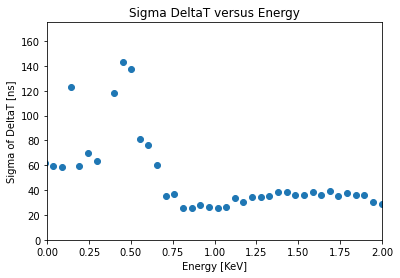

In [92]:
plt.scatter(energy_lis*0.0408625 -0.16892, sig*8)
plt.xlim(0,2)
plt.ylim(0,175)
plt.xlabel("Energy [KeV]")
plt.ylabel("Sigma of DeltaT [ns]")
plt.title("Sigma DeltaT versus Energy")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/sigTimeVsEnergy.pdf", facecolor = "white")
plt.show()

In [82]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]
energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line
energy = 12

pulse, rise_true = sigPulseSpecific(70,50,energy)
wave1 = copy.deepcopy(wave)
wp = wave1[0:15000] + pulse
w_trapTime = get_trap_time(wp)
max = np.mean(wp[11000:13000])
min = np.amin(wp)
m90 = max*0.9
m10 = max*0.1
m50 = max*0.5
imax51 = find_idx(wp, m50, w_trapTime)
imax9 = find_idxr(wp, m90, imax51)
imax1 = find_idx(wp, m10, imax51)
rise_cal = imax9 - imax1
deltat = abs(rise_cal - rise_true)
print(imax51)

10942


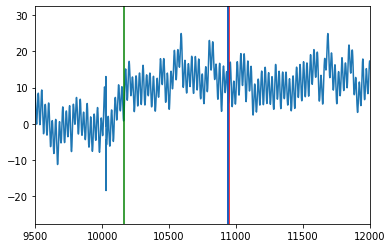

789
66


In [88]:
plt.plot(wp)
plt.axvline(w_trapTime)
plt.axvline(x = imax9, color='r', label = 'T10')
plt.axvline(x = imax1, color='g', label = 'T90')
plt.axvline(x = imax51, color='b', label = 'T50')
plt.axvline(imax51)
plt.xlim(9500,12000)
plt.show()
print(rise_cal)
print(rise_true)

In [64]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1][0:13000]

mean = sum(wave[1000:10000])/len(wave[1000:10000])
variance = sum([((x - mean) ** 2) for x in wave[1000:10000]]) / len(wave[1000:10000])
(variance ** 0.5) * 0.0408625 -0.16892
print(variance)


mean = sum(wp[0:5000])/len(wp[0:5000])
variance = sum([((x - mean) ** 2) for x in wp[0:5000]]) / len(wp[0:5000])
(variance ** 0.5)
print(variance)

254.65159955555345
19.952947032258564


In [84]:
w_trap = np.zeros(len(wp))

rise = int(6/.008)
flat = int(0.8/.008)

w_trap[0] = wp[0]/rise
for i in range(1, rise, 1):
    w_trap[i] = w_trap[i - 1] + wp[i] / rise
for i in range(rise, rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise])/rise
for i in range(rise + flat, 2 * rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise] - wp[i - rise - flat])/rise
for i in range(2 * rise + flat, len(wp), 1):
        w_trap[i] = (
        w_trap[i - 1]
        + (wp[i]
        - wp[i - rise]
        - wp[i - rise - flat]
        + wp[i - 2 * rise - flat])/rise
    )

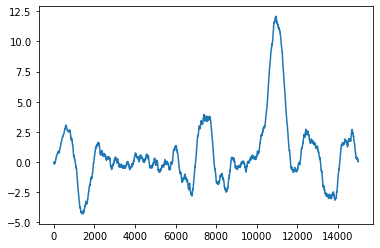

12.08307942988322


In [89]:
plt.plot(w_trap)
plt.show()
print(np.max(w_trap))

In [31]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0][0:15000]

w_trap = np.zeros(len(wave))

rise = int(6/.008)
flat = int(0.8/.008)

w_trap[0] = wp[0]/rise
for i in range(1, rise, 1):
    w_trap[i] = w_trap[i - 1] + wp[i] / rise
for i in range(rise, rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise])/rise
for i in range(rise + flat, 2 * rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise] - wp[i - rise - flat])/rise
for i in range(2 * rise + flat, len(wp), 1):
        w_trap[i] = (
        w_trap[i - 1]
        + (wp[i]
        - wp[i - rise]
        - wp[i - rise - flat]
        + wp[i - 2 * rise - flat])/rise
    )

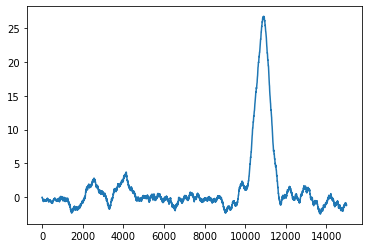

10918


In [32]:
plt.plot(w_trap)
plt.show()
print(np.argmax(w_trap))